In [1]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
sys.path

['',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages/setuptools-15.2-py2.7.egg',
 '/data/user/jbourbeau/metaprojects/icerec/trunk/build/lib',
 '/cvmfs/icecube.opensciencegrid.org/py2-v2/RHEL_6_x86_64/i3ports/root-v5.34.18/lib',
 '/home/jbourbeau/.local/lib/python2.7/site-packages',
 '/opt/rh/devtoolset-2/root/usr/lib64/python2.7/site-packages',
 '/opt/rh/devtoolset-2/root/usr/lib/python2.7/site-packages',
 '/cvmfs/icecube.opensciencegrid.org/py2-v2/RHEL_6_x86_64/lib/python2.7/site-packages',
 '/cvmfs/icecube.opensciencegrid.org/py2-v2/RHEL_6_x86_64/i3ports/lib/python2.7/site-packages',
 '/home/jbourbeau/cr-composition/analysis',
 '/home/jbourbeau',
 '/home/jbourbeau/useful',
 '/home/jbourbeau/anisotropy',
 '/home/jbourbeau/ShowerLLH_scripts',
 '/home/jbourbeau/cr-composition',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python27.zip',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7',
 '/cvmfs/icecube.opensc

In [8]:
import numpy as np
import pandas as pd
from pandas.tools.plotting import radviz
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns
from collections import defaultdict

from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve, GridSearchCV, cross_val_score, ParameterGrid
from sklearn.neighbors import KNeighborsClassifier

import composition as comp

# Plotting-related
sns.set_palette('muted')
sns.set_color_codes()
color_dict = defaultdict()
for i, composition in enumerate(['light', 'heavy', 'total']):
    color_dict[composition] = sns.color_palette('muted').as_hex()[i]
%matplotlib inline

In [9]:
sns.set_palette('muted')
sns.set_color_codes()

In [3]:
df, cut_dict = comp.load_dataframe(type_='sim', config='IT73', return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'StationDensity', 'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

feature_list, feature_labels = comp.get_training_features()
print('training features = {}'.format(feature_list))
X_train, X_test, y_train, y_test, le = comp.get_train_test_sets(
    df, feature_list)

print('number training events = ' + str(y_train.shape[0]))

/home/jbourbeau/cr-composition/composition/load_dataframe.py:88: RuntimeWarning: divide by zero encountered in log10
  df['log_NChannels_1_30'] = np.nan_to_num(np.log10(df['NChannels_1_30']))
/home/jbourbeau/cr-composition/composition/load_dataframe.py:89: RuntimeWarning: divide by zero encountered in log10
  df['log_NHits_1_30'] = np.nan_to_num(np.log10(df['NHits_1_30']))


training features = ['lap_log_energy', 'lap_cos_zenith', 'log_NChannels_1_30', 'log_s125', 'nchannels_nhits_ratio', 'lap_likelihood', 'log_NHits_1_30']
number training events = 145932


In [4]:
df['lap_likelihood'][df['MC_comp'] == 'He'].values[:100]

array([ -1.30412476,  -1.57385901,  -1.01663487,  -1.58376905,
        -1.00989601,  -0.71455711,  -0.77886031,  -1.07185769,
        -1.11143146,  -0.89604376,  -1.38911762,  -1.20401424,
        -1.20485737,  -1.81987366,  -0.83622682,  -1.22611465,
        -1.32099059,  -1.303859  ,  -1.02379808,  -0.86396626,
        -1.24409283,  -0.78822118,  -1.32140157,  -1.2752146 ,
        -1.17789774,  -0.87541731,  -0.6868446 ,  -1.2386133 ,
        -1.24929963,  -1.25692267,  -1.28884625,  -1.06075043,
        -1.44815366,  -1.11459266,  -1.14262954,  -1.35282971,
        -1.05475907,  -1.25123389,  -0.94833348,  -1.44373246,
        -0.82509381,  -0.90234551,  -1.20284723,  -1.22963704,
        -1.15737421,  -1.40724228,  -1.2004617 , -14.0718421 ,
        -1.13867399,  -7.8605686 ,  -1.20722066,  -1.25087001,
        -1.19948892,  -1.12484307,  -1.12562165,  -1.43004042,
        -1.29763623,  -1.12405603,  -0.99147217,  -1.07910855,
        -0.9915201 ,  -1.35868033,  -1.05577945,  -1.06

[-0.82676222 -0.8840413  -0.93437118 ..., -1.39546348 -7.45966724
 -5.77817865]
[-1.30412476 -1.57385901 -1.01663487 ..., -4.37190165 -3.89004181
 -6.0558187 ]
[-1.17612901 -0.88029814 -1.2713696  ..., -5.02006221 -6.22210791
 -1.38857627]
[-0.93470878 -1.18230596 -1.19489116 ..., -6.13183251 -1.29862343
 -1.43826772]


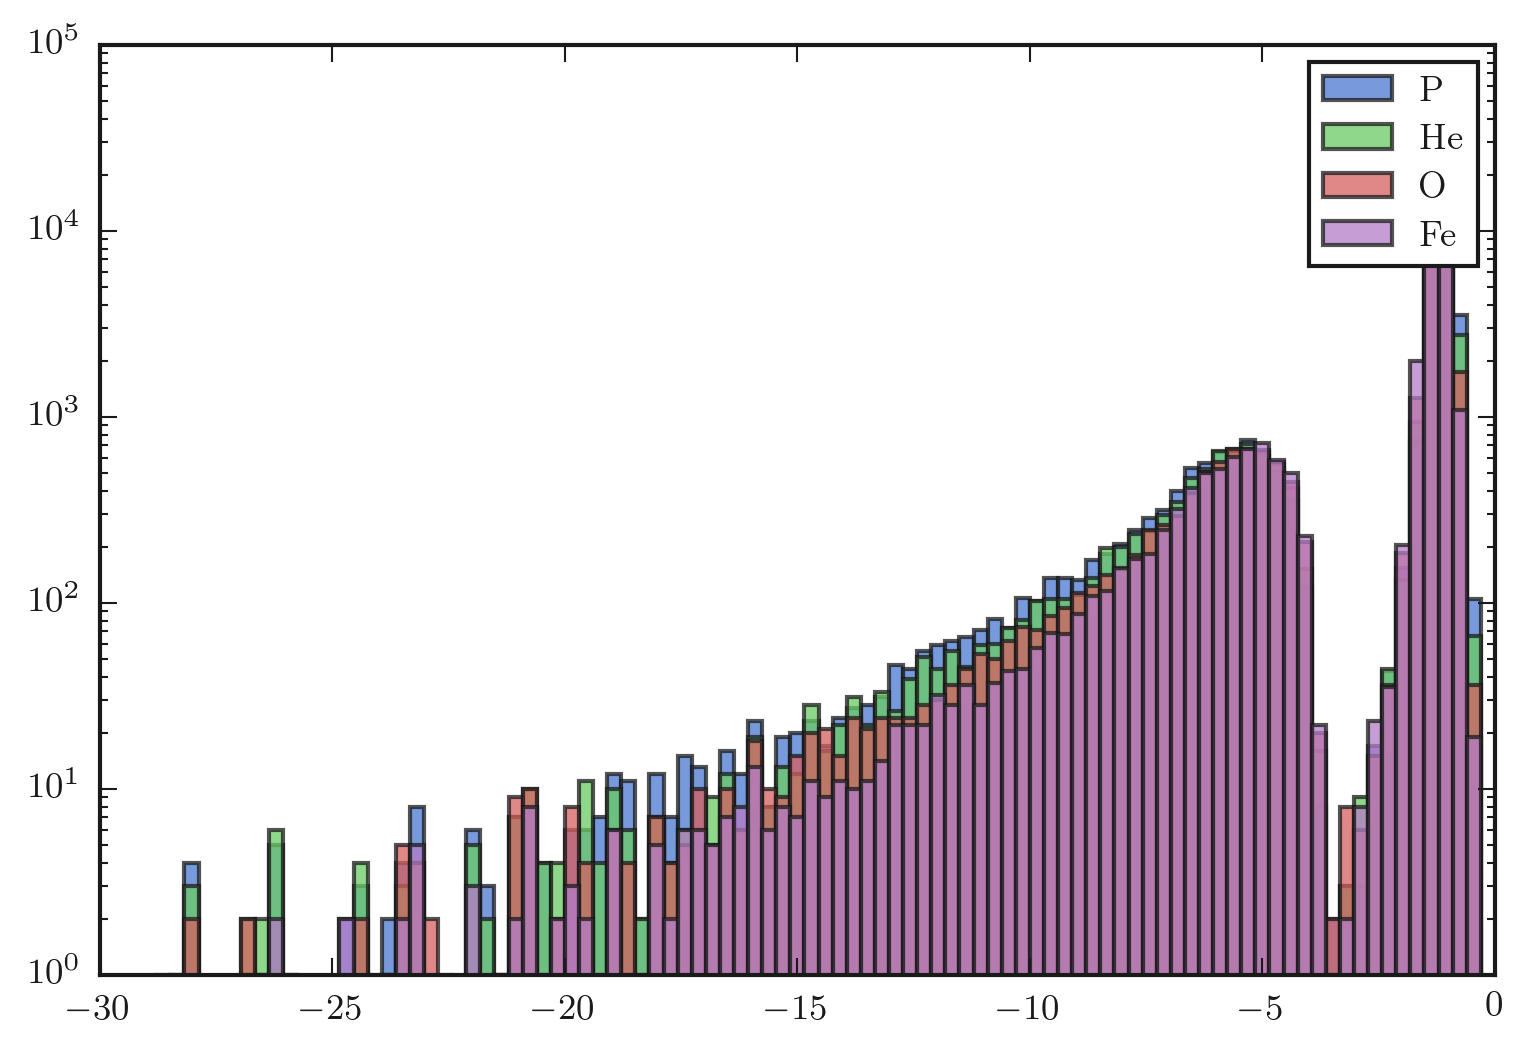

In [10]:
fig, ax = plt.subplots()
comp_list = ['P', 'He', 'O', 'Fe']
# comp_list = ['He', 'O']
for composition in comp_list:
    rlogl = df['lap_likelihood'][df['MC_comp'] == composition]
    print(rlogl.values)
    ax.hist(rlogl.values, bins=np.linspace(-30, 0, 100), log=True, label=composition, alpha=0.75)
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
comp_list = ['P', 'He', 'Fe']
for composition in comp_list:
    energy = df['lap_log_energy'][df['MC_comp'] == composition]
    ax.hist(energy, bins=np.linspace(6.2, 8, 100), log=True, label=composition, alpha=0.75)
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
comp_list = ['P', 'He', 'Fe']
for composition in comp_list:
    charge = df['InIce_log_charge_1_30'][df['MC_comp'] == composition]
    ax.hist(charge, bins=np.linspace(0, 6, 100), log=True, label=composition, alpha=0.75)
plt.legend()
plt.show()

In [ ]:
df, cut_dict = comp.load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_45_60', 'IT_signal',
                     'StationDensity', 'max_qfrac_45_60', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

fig, ax = plt.subplots()
comp_list = ['P', 'He', 'Fe']
for composition in comp_list:
    charge = df['InIce_log_charge_45_60'][df['MC_comp'] == composition]
    ax.hist(charge, bins=np.linspace(0, 6, 100), log=True, label=composition, alpha=0.75)
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
comp_list = ['P', 'He', 'Fe']
for composition in comp_list:
    nchannels = df['log_NChannels_1_30'][df['MC_comp'] == composition]
    ax.hist(nchannels, bins=np.linspace(0, 3, 100), log=True, label=composition, alpha=0.75)
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
comp_list = ['P', 'He', 'Fe']
for composition in comp_list:
    s125 = df['log_s125'][df['MC_comp'] == composition]
    ax.hist(s125, bins=np.linspace(0, 3, 100), log=True, label=composition, alpha=0.75)
plt.legend()
plt.show()